<a href="https://colab.research.google.com/github/PengjunHou/CSE437-RL/blob/main/lab2_mdp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Markov Decision Problems

# Exercise 1: Grid World
Compute the value funnction for the example 4.1 in the book.







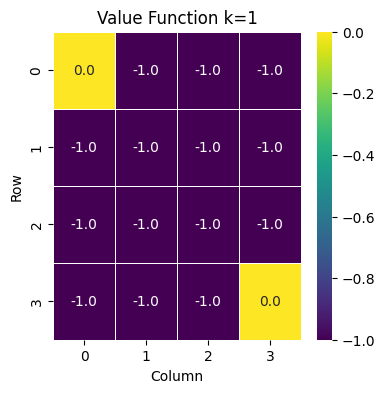

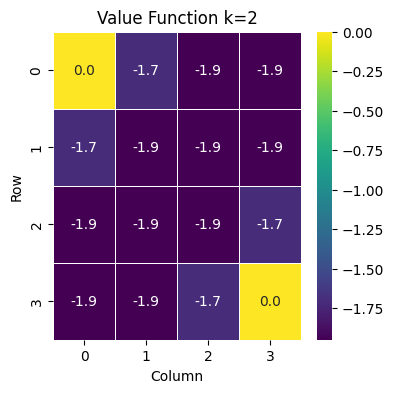

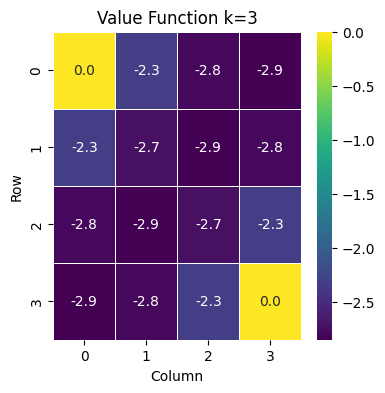

In [5]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

action2ind = {'left': (-1, 0), 'right': (1, 0), 'up': (0, -1), 'down':(0, 1)}

def step(s, a):
  x = s // 4
  y = s % 4

  new_x = x + action2ind[a][1]
  new_y = y + action2ind[a][0]

  if new_x >= 0 and new_x < 4:
    x = new_x
  if new_y >= 0 and new_y < 4:
    y = new_y

  return x * 4 + y

V = np.zeros(16)
gamma = 0.95  # Discount factor
V_old = np.zeros(16)


for k in range(3):
  for s in range(16):

    if s==0 or s==15:
      continue
    #### Write your code here #########
    tmp_V = 0
    for a in ['left', 'right', 'up', 'down']:
      next_s = step(s, a)
      r = -1
      tmp_V += 0.25 * (r + gamma * V_old[next_s])

    V[s] = tmp_V


  V_old = V.copy()




  ###### PLOT
  # Reshape the 1D value function array into an 8x8 grid
  V_grid = V.reshape((4, 4))

  # Plot the value function as a heatmap
  plt.figure(figsize=(4, 4))
  sns.heatmap(V_grid, annot=True, cmap="viridis", fmt=".1f", linewidths=.5)
  plt.title("Value Function k=%d"%(k+1))
  plt.xlabel("Column")
  plt.ylabel("Row")
  plt.show()

# Exercise 2: Grid World
Compute the optimal policy




In [11]:
# print(V)
a2arrow = {'left':'←', 'right':'→', 'up':'↑', 'down':'↓'}
Policy_Grid = [''] * 16
for s in range(16):
  if s == 0 or s == 15:
    continue
  best_a = ''
  best_v = -np.inf
  for a in ['left', 'right', 'up', 'down']:
    next_s = step(s, a)
    if V[next_s] >= best_v:
      best_v = V[next_s]
      best_a = a
  # print(f"s: {s}, best_v {best_v}, a {a}")
  for a in ['left', 'right', 'up', 'down']:
    next_s = step(s, a)
    if V[next_s] >= best_v:
      Policy_Grid[s] += a2arrow[a]
  # Policy_Grid[s] = best_a

Policy = np.array(Policy_Grid).reshape((4,4))
for i in range(4):
  print('\n')
  tmp = ''
  for j in range(4):
    tmp += f'{Policy_Grid[i*4 + j]}' + '\t'
  print(tmp)
# print(Policy)



	←	←	←	


↑	←↑	←	↓	


↑	↑	→↓	↓	


→↑	→	→		


# Exercise 3: Grid World
In the following gym environment, compute the value function using Monte Carlo.

Run the following code in your local machine. You can run in on colab, but you will not see the animation.

In [13]:
## Install https://github.com/damat-le/gym-simplegrid
!pip install gym_simplegrid

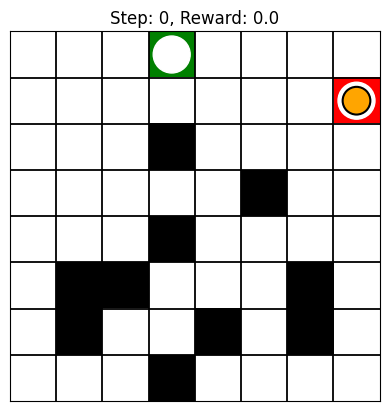

Episode 1/10
Episode 2/10
Episode 3/10
Episode 4/10
Episode 5/10
Episode 6/10
Episode 7/10
Episode 8/10
Episode 9/10
Episode 10/10

V(s) functions with Monte Carlo :
[[-0.95 -1.    1.    0.   -1.32 -1.6  -1.7  -1.6 ]
 [-1.31 -1.47 -3.49 -0.44 -2.59 -1.73 -3.66 -3.75]
 [-2.01 -1.91 -2.59  0.   -2.96 -2.03 -3.75 -4.32]
 [-1.6  -2.36 -4.13 -3.32 -3.73  0.   -4.41 -4.49]
 [-1.62 -1.86 -6.02  0.   -3.65 -3.55 -3.46 -5.18]
 [-1.54  0.    0.   -4.8  -4.06 -2.86  0.   -6.86]
 [-4.55  0.   -4.53 -4.68  0.   -2.57  0.   -8.38]
 [-4.66 -4.05 -6.06  0.   -5.04 -5.1  -7.15 -8.58]]


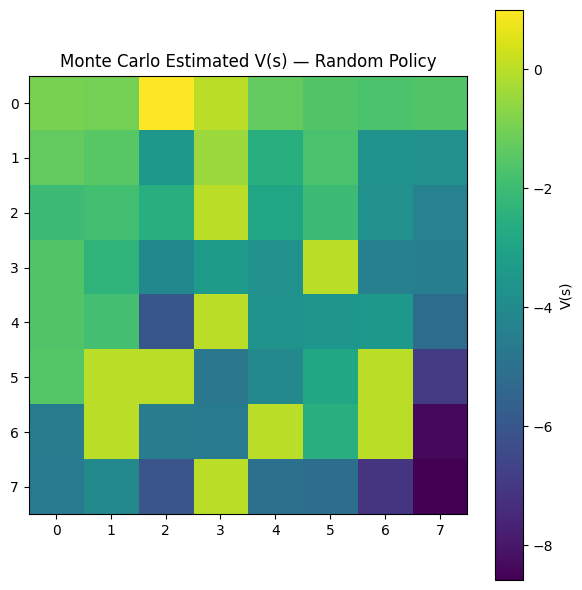

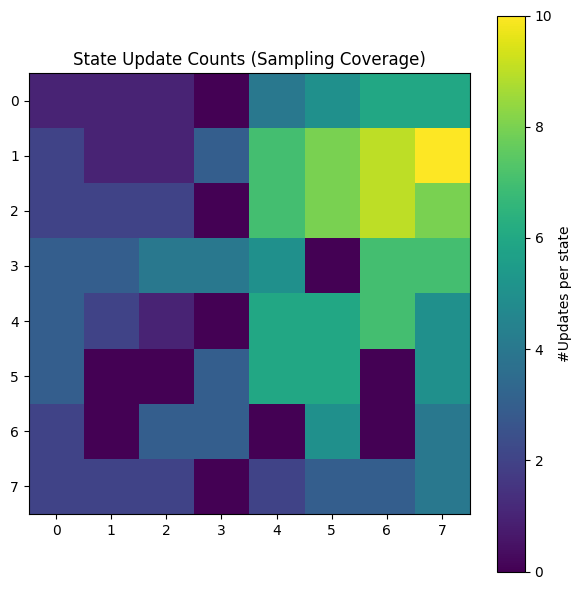

In [19]:

import gymnasium as gym
import gym_simplegrid

START_LOC = 15
GOAL_LOC = 3
EPISODES = 10
GAMMA = 0.95
FIRST_VISIT = True
GRID_SIZE = 8
SEED = 1
# Define the initial location and the goal location in the grid.
# Each grid cell has an a number from 0 to 63.
options ={
    'start_loc': START_LOC,
    'goal_loc': GOAL_LOC
}

env = gym.make('SimpleGrid-8x8-v0', render_mode='human')
obs, info = env.reset(seed=SEED, options=options)
done = env.unwrapped.done

def random_policy(env, obs):
    return env.action_space.sample()

def generate_episode(env, policy):
    obs, info = env.reset(seed=SEED, options=options)
    states, rewards = [], []
    terminated, truncated = False, False

    while not (terminated or truncated):
        states.append(obs)
        action = policy(env, obs)
        obs, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)

    return states, rewards

def monte_carlo_value(env, policy, episodes=10000, gamma=0.95, first_visit=True):
    n_states = env.observation_space.n
    returns_sum = np.zeros(n_states, dtype=np.float64)
    returns_cnt  = np.zeros(n_states, dtype=np.int64)
    V = np.zeros(n_states, dtype=np.float64)

    for ep in range(1, episodes + 1):
        states, rewards = generate_episode(env, policy)
        G = 0.0
        visited = set()

        # 从后往前累积折扣回报
        for t in reversed(range(len(states))):
            s = states[t]
            r = rewards[t]
            G = gamma * G + r

            if (not first_visit) or (s not in visited):
                returns_sum[s] += G
                returns_cnt[s]  += 1
                V[s] = returns_sum[s] / max(1, returns_cnt[s])
                visited.add(s)

        if episodes >= 10 and ep % (episodes // 10) == 0:
            print(f"Episode {ep}/{episodes}")

    return V, returns_cnt

V, counts = monte_carlo_value(env, random_policy, episodes=EPISODES, gamma=GAMMA, first_visit=FIRST_VISIT)

V_grid = V.reshape(GRID_SIZE, GRID_SIZE)
np.set_printoptions(precision=2, suppress=True)
print("\nV(s) functions with Monte Carlo :")
print(V_grid)

# plot heatmap
plt.figure(figsize=(6, 6))
plt.imshow(V_grid, origin="upper")
plt.colorbar(label="V(s)")
plt.title("Monte Carlo Estimated V(s) — Random Policy")
plt.xticks(range(GRID_SIZE)); plt.yticks(range(GRID_SIZE))
plt.tight_layout()
plt.savefig("mc_value_heatmap.png", dpi=160)
plt.show()

# state update cnt healmap
counts_grid = counts.reshape(GRID_SIZE, GRID_SIZE)
plt.figure(figsize=(6, 6))
plt.imshow(counts_grid, origin="upper")
plt.colorbar(label="#Updates per state")
plt.title("State Update Counts (Sampling Coverage)")
plt.xticks(range(GRID_SIZE)); plt.yticks(range(GRID_SIZE))
plt.tight_layout()
plt.savefig("mc_counts_heatmap.png", dpi=160)
plt.show()

# env.close()

# for t in range(10):
#     if done:
#         break
#     action = env.action_space.sample()   # Random action
#     obs, reward, done, _, info = env.step(action)

#     grid_size = 8
#     row = obs // grid_size
#     col = obs % grid_size
#     print("Location (", row, ",", col, ") t=",t, " reward=", reward, sep="")

# env.close()